# Python - HW8

## Zheng Nan Yang

In [26]:
data_location = 'sqlite:///../../data/data.db'

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

### Ingest and clean data

In [28]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [29]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc['ts'] = pd.to_datetime(ohlc['ts'])
ohlc.shape

(11627, 9)

In [30]:
tokens = ohlc.token.unique()

### Feature Engineering

In [31]:
#Adding new range feature
ohlc['range'] = ohlc['high'] - ohlc['low']

In [32]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain,range
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC,429.54
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC,538.60
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC,479.98
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC,1407.28
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC,902.08


In [33]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

In [34]:
data = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change(),
            volume_change = df.volume.pct_change()  #Adding new volume percentage change feature
        )[['ts', 'vol', 'ret', 'volume_change', 'range']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['vol', 'ret', 'volume_change', 'range']
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
])

In [35]:
data.shape

(1057, 45)

In [36]:
## Adding hour and day features
data['hour'] = data['ts'].dt.hour 
data['day'] = data['ts'].dt.dayofweek 
data = data.set_index('ts')

In [37]:
y = data.ret_SOL.shift(-1)[:-1]
X = data[:-1]

In [38]:
X.head()

,vol_BTC,ret_BTC,volume_change_BTC,range_BTC,vol_ETH,ret_ETH,volume_change_ETH,range_ETH,vol_USDT,ret_USDT,...,vol_AAVE,ret_AAVE,volume_change_AAVE,range_AAVE,vol_COMP,ret_COMP,volume_change_COMP,range_COMP,hour,day
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.0,NaN,NaN,429.54,0.0,NaN,NaN,31.62,0.0,NaN,...,0.0,NaN,NaN,2.253,0.0,NaN,NaN,7.56,0,0
2021-11-01 01:00:00,0.0,0.004357,0.296557,538.60,0.0,0.006874,0.858585,46.72,0.0,0.0000,...,0.0,0.008043,4.182691,5.416,0.0,-0.002281,-0.410075,4.24,1,0
2021-11-01 02:00:00,0.0,-0.004508,-0.054832,479.98,0.0,-0.005322,-0.405786,32.36,0.0,-0.0002,...,0.0,-0.009171,-0.695572,3.440,0.0,-0.006020,1.027650,7.47,2,0
2021-11-01 03:00:00,0.0,-0.012132,2.372884,1407.28,0.0,-0.013126,1.759066,114.63,0.0,0.0001,...,0.0,-0.013301,2.232113,8.732,0.0,-0.022273,0.304494,11.94,3,0
2021-11-01 04:00:00,0.0,-0.010186,-0.413717,902.08,0.0,-0.010679,-0.369918,66.86,0.0,0.0000,...,0.0,-0.016452,-0.305942,6.695,0.0,-0.024002,-0.338418,9.64,4,0


In [39]:
X.shape

(1056, 46)

In [40]:
y.shape

(1056,)

Let's analyze our data a little bit

In [41]:
y.describe()

count    1056.000000
mean       -0.000156
std         0.012010
min        -0.053429
25%        -0.007444
50%        -0.000503
75%         0.006740
max         0.048298
Name: ret_SOL, dtype: float64

In [42]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

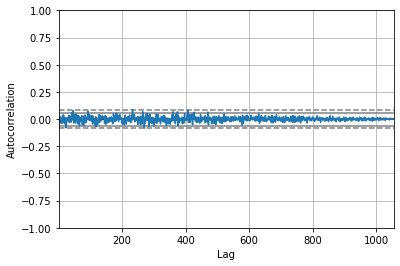

In [43]:
autocorrelation_plot(y[1:])
plt.show()

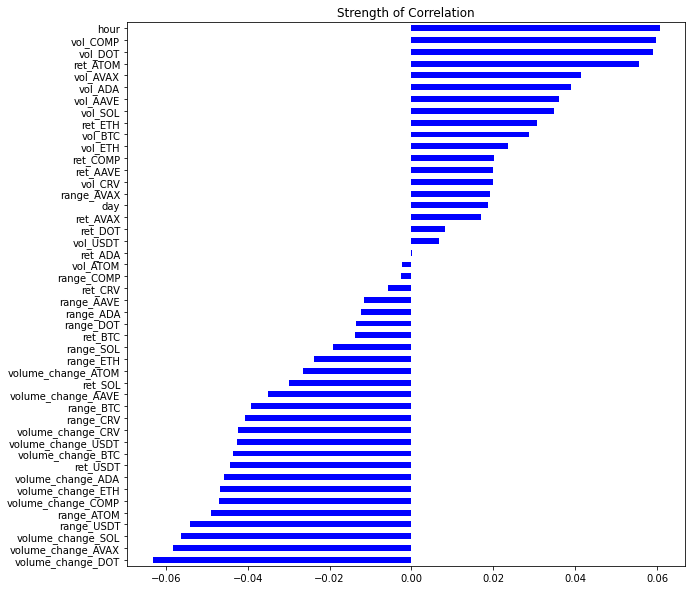

In [44]:
corr = X.corrwith(y)
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation', figsize=(10,10))
plt.show()

In [45]:
{col: y.corr(X[col]) for col in X.columns if X[col].dtype != 'object'}

{'vol_BTC': 0.028693550573573312,
 'ret_BTC': -0.013848623804147264,
 'volume_change_BTC': -0.043688618552662165,
 'range_BTC': -0.03927370884172279,
 'vol_ETH': 0.02357151289469288,
 'ret_ETH': 0.030649212659338235,
 'volume_change_ETH': -0.046803610805641646,
 'range_ETH': -0.02390510328737247,
 'vol_USDT': 0.00685018019131091,
 'ret_USDT': -0.04440085499052747,
 'volume_change_USDT': -0.0426840568329797,
 'range_USDT': -0.054189797093842036,
 'vol_SOL': 0.03485259726638474,
 'ret_SOL': -0.029855064193406493,
 'volume_change_SOL': -0.05630510667145637,
 'range_SOL': -0.019074265837455945,
 'vol_ADA': 0.038880233437007417,
 'ret_ADA': 0.00024928333961421933,
 'volume_change_ADA': -0.04586018089784545,
 'range_ADA': -0.012416216544274163,
 'vol_DOT': 0.05904076845167188,
 'ret_DOT': 0.008193946995455033,
 'volume_change_DOT': -0.06323246591949441,
 'range_DOT': -0.013566329331696221,
 'vol_AVAX': 0.04140851156078151,
 'ret_AVAX': 0.016919450289767074,
 'volume_change_AVAX': -0.05835418

### Model Selection

Next, let's set up a set of transformers so that we can augment our data before it hits the model

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [47]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [48]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer

In [49]:
#Creating seperate transformers for pre-processing numeric and categoric features

numeric_features = [x for x in X.columns if x not in ['hour', 'day']]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scaler', StandardScaler())])

categorical_features = ['hour', 'day']
categorical_transformer = OneHotEncoder(sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [50]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])

Preliminary testing to determine an appropriate class of model

In [51]:
from sklearn.linear_model import Lasso

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha = 1))
])

evaluate_model(pipeline, X, y)

-0.008570816681474391

In [52]:
from sklearn.linear_model import ElasticNet

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet(alpha = 0.5, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.008570816681474391

In [53]:
from sklearn.svm import SVR

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR(kernel = 'rbf'))
])

evaluate_model(pipeline, X, y)

-0.008546201345938906

In [54]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR(kernel = 'linear'))
])

evaluate_model(pipeline, X, y)

-0.008546201345938906

In [55]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR(kernel = 'poly'))
])

evaluate_model(pipeline, X, y)

-0.008546201345938906

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=10, max_depth = 1, learning_rate = 0.01, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.008574969541037024

The Support Vector Machine regression model with Linear kernel looks to be the most promising so we will focus our hyperparameter tuning on that model

### Hyperparameter Tuning

In [57]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR(kernel = 'rbf'))
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

#Setting up hyperparameter grid serach to look across values of C and epsilon in the SVM model
search = GridSearchCV(pipeline, {
    'model__C': [1, 10, 100, 1000],
    'model__epsilon':[0.1, 0.01, 0.001]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0.0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['vol_BTC',
                                                                          'ret_BTC',
                                               

In [58]:
search.best_params_

{'model__C': 1, 'model__epsilon': 0.1}

In [59]:
best_model = search.best_estimator_

In [60]:
evaluate_model(best_model, X, y)

-0.008546201345938906

### Final Model 

In [63]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

Let's check the learning curve of our best model

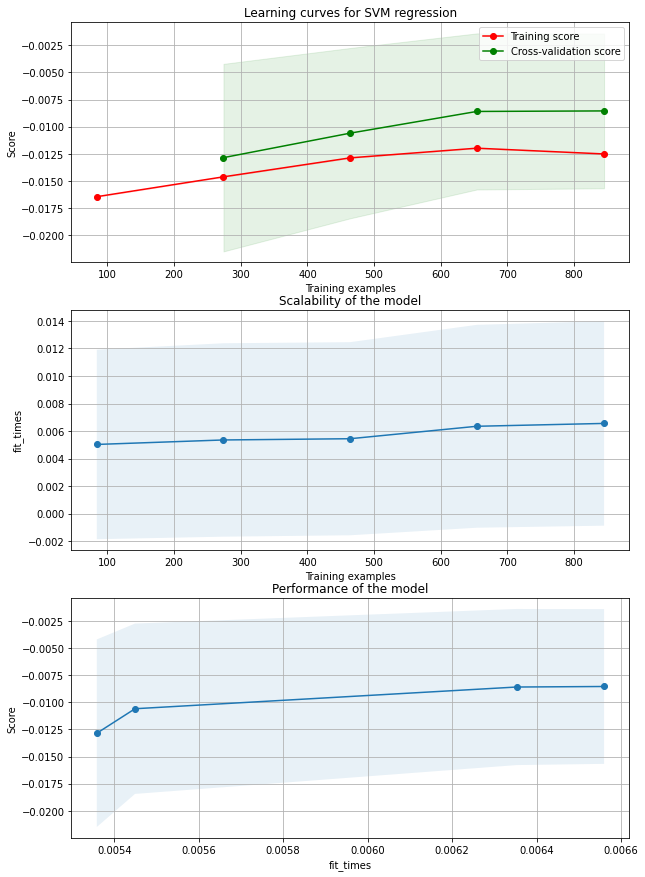

In [65]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for SVM regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)
plt.show()